In [0]:
import os ; os.chdir('/content/drive/My Drive/Colab Notebooks/Lazy courses/Recurrent Neural Network')

In [0]:
%tensorflow_version 1.x

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


i: 0 cost: 4875.169536232948 correct rate: 0.12960829493087558
i: 1 cost: 4295.698028206825 correct rate: 0.136026991441738
i: 2 cost: 4076.136852622032 correct rate: 0.1380842659644503
i: 3 cost: 3895.211296081543 correct rate: 0.14170506912442396
i: 4 cost: 3701.2695318460464 correct rate: 0.1423633969716919
i: 5 cost: 3528.117562532425 correct rate: 0.14310401579986834
i: 6 cost: 3385.2514047026634 correct rate: 0.14195194206714945
i: 7 cost: 3246.9724522829056 correct rate: 0.14433838051349573
i: 8 cost: 3130.37495970726 correct rate: 0.14507899934167215
i: 9 cost: 3076.7901846170425 correct rate: 0.1433508887425938
i: 10 cost: 2987.2108675837517 correct rate: 0.14409150757077024
i: 11 cost: 2947.1869999170303 correct rate: 0.1423633969716919
i: 12 cost: 2930.3765691518784 correct rate: 0.14112903225806453
i: 13 cost: 2864.8920047283173 correct rate: 0.14400921658986174
i: 14 cost: 2833.222780287266 correct rate: 0.14351547070441079
i: 15 cost: 2814.5393223166466 correct rate: 0.14

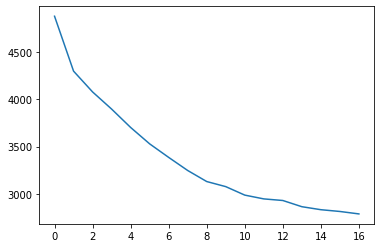

in slower as city ahead me look the serial things 
and being from would was 
he cottage a hands— it living to saw near for going to warn 
you donkeys the white you wont knock expense knees 


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from utils import init_weight, get_robert_frost, get_wikipedia_data

class SimpleRNN:
    def __init__(self, D, M, V, f, session):
        self.D = D # dimensionality of word embedding
        self.M = M # hidden layer size
        self.V = V # vocabulary size
        self.f = f
        self.session = session

    def set_session(self, session):
        self.session = session

    def build(self, We, Wx, Wh, bh, h0, Wo, bo):
        #make them tf variables
        self.We = tf.Variable(We)
        self.Wx = tf.Variable(Wx)
        self.Wh = tf.Variable(Wh)
        self.bh = tf.Variable(bh)
        self.h0 = tf.Variable(h0)
        self.Wo = tf.Variable(Wo)
        self.bo = tf.Variable(bo)
        self.params = [self.We, self.Wx, self.Wh, self.bh, self.h0, self.Wo, self.bo]

        #for easy access
        V = self.V
        D = self.D
        M = self.M

        #placeholders
        self.tfX = tf.placeholder(tf.int32, shape=(None,), name='X')
        self.tfY = tf.placeholder(tf.int32, shape=(None,), name='Y')

        #convert word indexes to word vectors
        #this would be equivalent to doing 
        #We[tfX] in Numpy / Theano
        #or :
        # X_one_hot = one_hot_encode(X)
        # X_one_hot.dot(We)
        XW = tf.nn.embedding_lookup(We, self.tfX)

        #multiply it by input-->hidden so that we dont have to do it 
        #inside recurrence function
        XW_Wx = tf.matmul(XW, self.Wx)

        def recurrence(h_t1, XW_Wx_t):
            #returns h(t) and y(t)
            h_t1 = tf.reshape(h_t1, (1,M))
            h_t = self.f(XW_Wx_t + tf.matmul(h_t1, self.Wh) + self.bh)
            h_t = tf.reshape(h_t, (M,))
            return h_t
            
        h = tf.scan(
            fn = recurrence,
            elems=XW_Wx,
            initializer=self.h0,
        )

        #output
        logits = tf.matmul(h, self.Wo) + self.bo
        prediction = tf.argmax(logits, 1)
        self.output_probs = tf.nn.softmax(logits)

        nce_weights = tf.transpose(self.Wo, [1,0]) #needs to be VxD, not DxV
        nce_biases = self.bo

        h = tf.reshape(h, (-1,M))
        labels = tf.reshape(self.tfY, (-1, 1))

        self.cost = tf.reduce_mean(
            tf.nn.sampled_softmax_loss(
                weights=nce_weights,
                biases = nce_biases,
                labels = labels,
                inputs = h,
                num_sampled = 50, #number of negative sample
                num_classes =  V))

        self.predict_op = prediction
        self.train_op = tf.train.AdamOptimizer(1e-2).minimize(self.cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-3, 0.9).minimize(self.cost)

        #init all variables 
        init = tf.global_variables_initializer()
        self.session.run(init)

    def fit(self, X, epochs=500, show_fig=False):
        N = len(X)
        D = self.D
        M = self.M
        V = self.V

        #initial weights 
        We = init_weight(V, D).astype(np.float32)
        Wx = init_weight(D, M).astype(np.float32)
        Wh = init_weight(M, M).astype(np.float32)
        bh = np.zeros(M).astype(np.float32)
        h0 = np.zeros(M).astype(np.float32)
        Wo = init_weight(M, V).astype(np.float32)
        bo = np.zeros(V).astype(np.float32)

        #build tensorflow functions
        self.build(We, Wx, Wh, bh, h0, Wo, bo)

        # sentence input:
        # [START, w1, w2, ..., wn]
        # sentence target:
        # [w1, w2, w3, ..., END]

        costs = []
        n_total = sum((len(sentence)+1) for sentence in X)
        for i in range(epochs):
            X = shuffle(X)
            n_correct = 0
            cost = 0 
            for j in range(N):
                # problem! many words --> END token are over-represented
                # result: generated lines will be very short
                # we will try to fix in a later iteration
                # bad! magic numbers 0 and 1
                input_sequence = [0] + X[j]
                output_sequence = X[j] + [1]

                # we set 0 to start and 1 to end
                _, c, p = self.session.run(
                    (self.train_op, self.cost, self.predict_op),
                    feed_dict={self.tfX: input_sequence, self.tfY: output_sequence}
                )

                cost += c
                for pj, xj in zip(p, output_sequence):
                    if pj == xj:
                        n_correct += 1
            print("i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total))
            costs.append(cost)

        if show_fig:
            plt.plot(costs)
            plt.show()

    def predict(self, prev_words):
        #don't use argmax, so that we can sample 
        #from this probability distribution
        return self.session.run(self.output_probs, feed_dict={self.tfX: prev_words})

    def save(self, filename):
        actual_params = self.session.run(self.params)
        np.savez(filename, *[p for p in actual_params])

    @staticmethod
    def load(filename, activation, session):
        npz = np.load(filename)
        We = npz['arr_0']
        Wx = npz['arr_1']
        Wh = npz['arr_2']
        bh = npz['arr_3']
        h0 = npz['arr_4']
        Wo = npz['arr_5']
        bo = npz['arr_6']
        V, D = We.shape
        _, M = Wx.shape
        rnn = SimpleRNN(D, M, V, activation, session)
        rnn.build(We, Wx, Wh, bh, h0, Wo, bo)
        return rnn

    def generate(self, pi, word2idx):
        #convert word2idx --> idx2word
        idx2word = {v:k for k,v in word2idx.items()}
        V = len(pi)

        #generate 4 lines at a time 
        n_lines = 0

        #why? START symbol will always yield the same first word 
        X = [np.random.choice(V, p=pi)]

        print(idx2word[X[0]], end=" ")

        while n_lines < 4:
            probs = self.predict(X)[-1]
            word_idx = np.random.choice(V, p=probs)
            X.append(word_idx)
            if word_idx > 1:
                #its a real word, not a start/end token
                word = idx2word[word_idx]
                print(word, end=" ")
            elif word_idx == 1:
                #end token
                n_lines += 1
                print('')
                if n_lines < 4:
                    X = [np.random.choice(V, p=pi)] #reset to start of the line
                    print(idx2word[X[0]], end=" ")


def train_poetry(session, dims, savefile):
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN(dims, dims, len(word2idx), tf.nn.relu, session)
    rnn.fit(sentences, epochs=17, show_fig=True)
    rnn.save(savefile)

def generate_poetry(session, savefile):
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN.load(savefile, tf.nn.relu, session)

    #determine initial state distribution for starting sentences
    V = len(word2idx)
    pi = np.zeros(V)
    for sentence in sentences:
        pi[sentence[0]] += 1

    pi /= pi.sum()

    rnn.generate(pi, word2idx)


if __name__ == "__main__":
    dims=50
    savefile = 'RNN_D50_M50_tf.npz'
    session = tf.InteractiveSession()
    #session = tf.compat.v1.InteractiveSession()
    train_poetry(session, dims, savefile)
    generate_poetry(session, savefile)


In [8]:
if __name__ == "__main__":
    dims=50
    savefile = 'RNN_D50_M50_tf.npz'
    session = tf.InteractiveSession()
    #session = tf.compat.v1.InteractiveSession()
    #train_poetry(session, dims, savefile)
    generate_poetry(session, savefile)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


by idleness to picked 
you scene down to sell 
hell brush 
the clothes than of birth or 


In [9]:
if __name__ == "__main__":
    dims=50
    savefile = 'RNN_D50_M50_tf.npz'
    session = tf.InteractiveSession()
    #session = tf.compat.v1.InteractiveSession()
    #train_poetry(session, dims, savefile)
    generate_poetry(session, savefile)

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


that less he lean enough morning 
i bigger tended 
faster course and berries all in some married with 
here faced this picture house stole not me rain let strands born 
